In [1]:
import pandas as pd
import numpy as np
import json

# read in cleaned text of articles (from clean_articles.py)
df_art = pd.read_csv('clean_articles.csv')
df_art.word_counts = df_art.word_counts.apply(lambda x: x[8:-1].replace("'", "\""))
df_art.word_counts = df_art.word_counts.apply(json.loads)

# configure as string text and classification
df_art['as_str'] = df_art.word_counts.apply(lambda x: ' '.join([k for k,v in x.items() for i in range(v)]))
feat = df_art[['as_str', 'subreddit']]
feat

,as_str,subreddit
0,data data data data data data data data data d...,nottheonion
1,said said said said said said said officer off...,nottheonion
2,given given employee employee energy energy ne...,nottheonion
3,school school school school school shooting sh...,nottheonion
4,gorilla gorilla gorilla gorilla gorilla gorill...,nottheonion
...,...,...
1555,advocacy advocacy awarded global fight surpris...,TheOnion
1556,shit shit shit people people word word said sa...,TheOnion
1557,slide slide slide slide slide slide slide slid...,TheOnion
1558,would would would recommendation recommendatio...,TheOnion


In [8]:
feat.subreddit.value_counts()

TheOnion       864
nottheonion    696
Name: subreddit, dtype: int64

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from text_func import process_text

def train_test_svm(df, vectorizer=TfidfVectorizer(), kernel='linear', C=1.0, k=5):
    ''' train and test SVM on feature vectors
    arg. 
        feat: dataframe with text and classification
        vectorizer: TFIDF or CountVectorizer
        kernel: kernel for SVM
        C: regularization parameter for SVM
        k: number of folds for cross-validation
    returns.
        acc_v: accuracy of SVM
    '''
    acc = []
    
    kf = KFold(n_splits=k, shuffle=True, random_state=13)
    for train_indices, test_indices in kf.split(df):
        
        # divide into train and test sets
        train_df = df.iloc[train_indices]
        test_df = df.iloc[test_indices]
        
        X_train, y_train = train_df.as_str, train_df.subreddit
        X_test, y_test = test_df.as_str, test_df.subreddit
        
        # vectorize text
        vect = vectorizer

        # build feature vectors
        X_train_v = vect.fit_transform(X_train)
        X_test_v = vect.transform(X_test)
        
        # train SVM
        svm_v = SVC(kernel=kernel, C=C)
        svm_v.fit(X_train_v, y_train)
        
        # test SVM
        y_pred_v = svm_v.predict(X_test_v)

        # evaluate score and add to list
        acc.append(accuracy_score(y_test, y_pred_v))

    return np.average(acc)

def svm_model(df, vectorizer=TfidfVectorizer(), kernel='linear', C=1.0):
    ''' train and test SVM on feature vectors
    arg. 
        feat: dataframe with text and classification
        vectorizer: TFIDF or CountVectorizer
        kernel: kernel for SVM
        C: regularization parameter for SVM
    returns.
        svm_v: model
        vect: vectorizer
    '''
    X, y = df.as_str, df.subreddit
    
    # vectorize text
    vect = vectorizer

    # build feature vectors
    X_v = vect.fit_transform(X)
    
    # train SVM
    svm_v = SVC(kernel=kernel, C=C)
    svm_v.fit(X_v, y)
    
    return svm_v, vect

def predict_onion(model, text, vectorizer):
    ''' predict classification of text
    arg. 
        model: trained model
        text: string of text
        vectorizer: TFIDF or CountVectorizer
    returns.
        y_pred_v: predicted classification
    '''
    
    X = [process_text(text)]
    
    # vectorize text
    vect = vectorizer

    # build feature vectors
    X_v = vect.transform(X)
    
    # predict
    y_pred_v = model.predict(X_v)
    
    return y_pred_v[0]

In [3]:
# shuffle data
shuffled = feat.sample(frac=1, random_state=13)

# test function with TfidfVectorizer
acc_tf = train_test_svm(shuffled, vectorizer=TfidfVectorizer())

# test function with CountVectorizer
acc_cv = train_test_svm(shuffled, vectorizer=CountVectorizer())

print(f'TF-IDF accuracy: {round(acc_tf, 4)*100}%')
print(f'CountVectorizer accuracy: {round(acc_cv, 4)*100}%')

TF-IDF accuracy: 93.08%
CountVectorizer accuracy: 90.13%


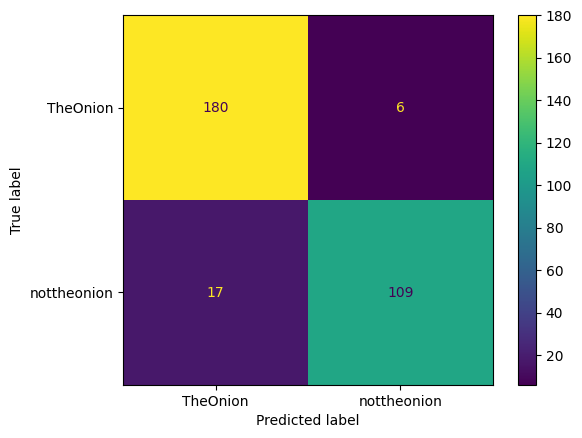

In [4]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def confusion_matrix_svm(df, vectorizer=TfidfVectorizer(), kernel='linear', C=1.0):
    # Confusion matrix of TF-IDF SVM model on train test split
    X, y = df.as_str, df.subreddit
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)
    
    # vectorize text
    vect = vectorizer

    # build feature vectors
    X_train_v = vect.fit_transform(x_train)
    X_test_v = vect.transform(x_test)

    # train SVM
    svm_v = SVC(kernel=kernel, C=C)
    svm_v.fit(X_train_v, y_train)

    # test SVM
    y_pred_v = svm_v.predict(X_test_v)
    return confusion_matrix(y_test, y_pred_v), svm_v.classes_

cm, labels = confusion_matrix_svm(shuffled)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()

### example of model in use
from https://www.theonion.com/louisville-no-way-to-prevent-this-says-only-nation-w-1850319203


In [5]:
onion_article = 'LOUISVILLE, KY—In the hours following a violent rampage in Kentucky in which a lone attacker killed at least five individuals and injured six others, citizens living in the only country where this kind of mass killing routinely occurs reportedly concluded Monday that there was no way to prevent the massacre from taking place. “This was a terrible tragedy, but sometimes these things just happen and there’s nothing anyone can do to stop them,” said Ohio resident Pete Anderson, echoing sentiments expressed by tens of millions of individuals who reside in a nation where over half of the world’s deadliest mass shootings have occurred in the past 50 years and whose citizens are 20 times more likely to die of gun violence than those of other developed nations. “It’s a shame, but what can we do? There really wasn’t anything that was going to keep this individual from snapping and killing a lot of people if that’s what they really wanted.” At press time, residents of the only economically advanced nation in the world where roughly two mass shootings have occurred every month for the past eight years were referring to themselves and their situation as “helpless.”'

In [6]:
# build model and test on onion article
tfidf_model, tfidf_vect = svm_model(shuffled, vectorizer=TfidfVectorizer())
predict_onion(tfidf_model, onion_article, tfidf_vect)

'TheOnion'